<a href="https://colab.research.google.com/github/itaborai83/ecd221-ML-trabalho/blob/main/ML_7_Projeto_completo_de_Classifica%C3%A7%C3%A3o_Bin%C3%A1ria_Telco_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Especialização em Ciência de Dados - PUC-Rio
# Machine Learning - Prof. Tatiana Escovedo
# Projeto completo de Classificação Binária


## 1. Definição do Problema

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

**Informações sobre os atributos:**

Adicionar

In [1]:
# função de correlação que funciona com variáveis categóricas e numéricas
! pip install phik


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 10.0 MB/s 


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import phik
from phik.report import plot_correlation_matrix
from phik import report

In [3]:
# setup ambiente

# supressão de warnings
import warnings
warnings.filterwarnings("ignore")

# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

# configura cores do Seaborn
sns.set()

In [136]:
# constantes

DATA_URL                    = f"https://raw.githubusercontent.com/itaborai83/ecd221-ML-trabalho/main/telco-churn.csv"
FIELD_SEPARATOR             = ","
IMPORT_COLUMN_NAMES         = [
    "customer_id"
,   "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "tenure"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
COLUMN_NAMES = [
    "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "tenure"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
TARGET_VARIABLE = "churn"
BOOLEAN_FEATURES = [
    "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "paperless_billing"
]
CATEGORICAL_FEATURES = [
    "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "payment_method"
]
NUMERICAL_FEATURES = ["tenure", "monthly_charges", "total_charges"]
BOOLEAN_MAP = {"No": 0, "Yes": 1}


## 2. Carga de Dados

Iremos usar o pacote Pandas ( Python Data Analysis Library) para carregar de um arquivo .csv sem cabeçalho disponível online.

Com o dataset carregado, iremos explorá-lo um pouco.

In [137]:
# Carrega arquivo csv usando Pandas usando uma URL
churn_df = pd.read_csv(
    DATA_URL
,   names     = IMPORT_COLUMN_NAMES
,   skiprows  = 1
,   delimiter = ','
)

# transforma a variável target em uma variável numérica
churn_df["churn"] = churn_df["churn"].map(BOOLEAN_MAP)

# excluindo a variável customer_id
del churn_df["customer_id"]

# excluindo a variável sexo pois não foi encontrado nenhum cenário onde o mesmo impactasse o resultado
del churn_df["gender"]

# variável total_charges possui linhas com valor = ' '
churn_df["total_charges"] = churn_df["total_charges"].replace(' ', 0).astype(float)

# transformando variáveis booleanas em numéricas (one hot encoding não é necessário)
for feature in BOOLEAN_FEATURES:
  if feature == "senior_citizen":      
      continue # a variável já consta como numérica no dataset
  churn_df[feature] = churn_df[feature].map(BOOLEAN_MAP)

# movendo as variáveis categóricas para o começo do dataframe e as numéricas para o final
#churn_df["tenure"]          = churn_df.pop("tenure")
#churn_df["monthly_charges"] = churn_df.pop("monthly_charges")
#churn_df["total_charges"]   = churn_df.pop("total_charges")
#churn_df["churn"]           = churn_df.pop("churn")

orig_df = churn_df.copy()

# realizando o one hot encoding usando pandas
ohe_df = pd.get_dummies(
    data        = churn_df[CATEGORICAL_FEATURES]
,   prefix      = CATEGORICAL_FEATURES
,   prefix_sep  = "="
)

churn_df = pd.concat([
    churn_df[ BOOLEAN_FEATURES ]
,   ohe_df
,   churn_df[ NUMERICAL_FEATURES ]
,   churn_df[ TARGET_VARIABLE ]
], axis=1)


# removendo variáveis equivalentes internet_service=No = 1
del churn_df["device_protection=No internet service"]
del churn_df["streaming_tv=No internet service"]
del churn_df["tech_support=No internet service"]
del churn_df["online_backup=No internet service"]
del churn_df["streaming_movies=No internet service"]
del churn_df["online_security=No internet service"]

# removendo variáveis equivalentes phone_service=0
del churn_df["multiple_lines=No phone service"]

# removendo variáveis codificada tornadas redundantes pelas deleções acima
del churn_df["multiple_lines=No"]
del churn_df["online_security=No"]
del churn_df["online_backup=No"]
del churn_df["device_protection=No"]
del churn_df["tech_support=No"]
del churn_df["streaming_tv=No"]
del churn_df["streaming_movies=No"]


In [131]:
churn_df.head()

,senior_citizen,partner,dependents,phone_service,paperless_billing,gender=Female,gender=Male,multiple_lines=Yes,internet_service=DSL,internet_service=Fiber optic,...,contract=One year,contract=Two year,payment_method=Bank transfer (automatic),payment_method=Credit card (automatic),payment_method=Electronic check,payment_method=Mailed check,tenure,monthly_charges,total_charges,churn
0,0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,1,29.85,29.85,0
1,0,0,0,1,0,0,1,0,1,0,...,1,0,0,0,0,1,34,56.95,1889.50,0
2,0,0,0,1,1,0,1,0,1,0,...,0,0,0,0,0,1,2,53.85,108.15,1
3,0,0,0,0,0,0,1,0,1,0,...,1,0,1,0,0,0,45,42.30,1840.75,0
4,0,0,0,1,1,1,0,0,0,1,...,0,0,0,0,1,0,2,70.70,151.65,1


## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [117]:
# Mostra as dimensões do dataset
print(churn_df.shape)

(7043, 36)


In [132]:
# Mostra as informações do dataset
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   senior_citizen                            7043 non-null   int64  
 1   partner                                   7043 non-null   int64  
 2   dependents                                7043 non-null   int64  
 3   phone_service                             7043 non-null   int64  
 4   paperless_billing                         7043 non-null   int64  
 5   gender=Female                             7043 non-null   uint8  
 6   gender=Male                               7043 non-null   uint8  
 7   multiple_lines=Yes                        7043 non-null   uint8  
 8   internet_service=DSL                      7043 non-null   uint8  
 9   internet_service=Fiber optic              7043 non-null   uint8  
 10  internet_service=No                 

In [119]:
# Mostra as 10 primeiras linhas do dataset
churn_df.head(10)

,senior_citizen,partner,dependents,phone_service,paperless_billing,gender=Female,gender=Male,multiple_lines=No,multiple_lines=No phone service,multiple_lines=Yes,...,contract=One year,contract=Two year,payment_method=Bank transfer (automatic),payment_method=Credit card (automatic),payment_method=Electronic check,payment_method=Mailed check,tenure,monthly_charges,total_charges,churn
0,0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,1,29.85,29.85,0
1,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,1,34,56.95,1889.50,0
2,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,1,2,53.85,108.15,1
3,0,0,0,0,0,0,1,0,1,0,...,1,0,1,0,0,0,45,42.30,1840.75,0
4,0,0,0,1,1,1,0,1,0,0,...,0,0,0,0,1,0,2,70.70,151.65,1
5,0,0,0,1,1,1,0,0,0,1,...,0,0,0,0,1,0,8,99.65,820.50,1
6,0,0,1,1,1,0,1,0,0,1,...,0,0,0,1,0,0,22,89.10,1949.40,0
7,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,10,29.75,301.90,0
8,0,1,0,1,1,1,0,0,0,1,...,0,0,0,0,1,0,28,104.80,3046.05,1
9,0,0,1,1,0,0,1,1,0,0,...,1,0,1,0,0,0,62,56.15,3487.95,0


In [120]:
# Mostra as 10 últimas linhas do dataset
churn_df.tail(10)

,senior_citizen,partner,dependents,phone_service,paperless_billing,gender=Female,gender=Male,multiple_lines=No,multiple_lines=No phone service,multiple_lines=Yes,...,contract=One year,contract=Two year,payment_method=Bank transfer (automatic),payment_method=Credit card (automatic),payment_method=Electronic check,payment_method=Mailed check,tenure,monthly_charges,total_charges,churn
7033,0,0,0,1,1,0,1,1,0,0,...,0,0,0,1,0,0,38,69.50,2625.25,0
7034,0,0,0,1,1,1,0,0,0,1,...,0,0,0,1,0,0,67,102.95,6886.25,1
7035,0,0,0,1,1,0,1,1,0,0,...,0,0,1,0,0,0,19,78.70,1495.10,0
7036,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,12,60.65,743.30,0
7037,0,0,0,1,1,1,0,1,0,0,...,0,1,1,0,0,0,72,21.15,1419.40,0
7038,0,1,1,1,1,0,1,0,0,1,...,1,0,0,0,0,1,24,84.80,1990.50,0
7039,0,1,1,1,1,1,0,0,0,1,...,1,0,0,1,0,0,72,103.20,7362.90,0
7040,0,1,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,11,29.60,346.45,0
7041,1,1,0,1,1,0,1,0,0,1,...,0,0,0,0,0,1,4,74.40,306.60,1
7042,0,0,0,1,1,0,1,1,0,0,...,0,1,1,0,0,0,66,105.65,6844.50,0


É sempre importante verificar o tipo do atributos do dataset, pois pode ser necessário realizar conversões. Já fizemos anteriormente com o comando info, mas vamos ver uma outra forma de verificar a natureza de cada atributo e então exibir um resumo estatístico do dataset.

In [121]:
# Verifica o tipo de dataset de cada atributo
churn_df.dtypes

senior_citizen                                int64
partner                                       int64
dependents                                    int64
phone_service                                 int64
paperless_billing                             int64
gender=Female                                 uint8
gender=Male                                   uint8
multiple_lines=No                             uint8
multiple_lines=No phone service               uint8
multiple_lines=Yes                            uint8
internet_service=DSL                          uint8
internet_service=Fiber optic                  uint8
internet_service=No                           uint8
online_security=No                            uint8
online_security=Yes                           uint8
online_backup=No                              uint8
online_backup=Yes                             uint8
device_protection=No                          uint8
device_protection=Yes                         uint8
tech_support

In [122]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
churn_df.describe()

,senior_citizen,partner,dependents,phone_service,paperless_billing,gender=Female,gender=Male,multiple_lines=No,multiple_lines=No phone service,multiple_lines=Yes,...,contract=One year,contract=Two year,payment_method=Bank transfer (automatic),payment_method=Credit card (automatic),payment_method=Electronic check,payment_method=Mailed check,tenure,monthly_charges,total_charges,churn
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,...,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.16,0.48,0.30,0.90,0.59,0.50,0.50,0.48,0.10,0.42,...,0.21,0.24,0.22,0.22,0.34,0.23,32.37,64.76,2279.73,0.27
std,0.37,0.50,0.46,0.30,0.49,0.50,0.50,0.50,0.30,0.49,...,0.41,0.43,0.41,0.41,0.47,0.42,24.56,30.09,2266.79,0.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25,0.00,0.00
25%,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,9.00,35.50,398.55,0.00
50%,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,29.00,70.35,1394.55,0.00
75%,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,55.00,89.85,3786.60,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,72.00,118.75,8684.80,1.00


Vamos agora verificar se o dataset tem as classes balanceadas para que possamos tratar o desbalanceamento posteriormente, se necessário. Veremos que as classes 0 (não ocorrência de diabetes) e 1 (ocorrência de diabetes) estão desbalanceadas. Vamos guardar esta informação, pois possivelmente precisaremos realizar algum tipo de tratamento nas próximas etapas.

In [19]:
# distribuição das classes
pd.crosstab(churn_df[TARGET_VARIABLE], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
churn,,
No,0.73,0.00
Yes,0.00,0.27


In [89]:
# tabulação cruzada
pd.crosstab(churn_df["gender"], churn_df[TARGET_VARIABLE], normalize=True)

KeyError: ignored

In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["senior_citizen"], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
senior_citizen,,
No,0.64,0.20
Yes,0.09,0.07


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["partner"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
partner,,
No,0.35,0.17
Yes,0.39,0.09


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["dependents"], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
dependents,,
No,0.48,0.22
Yes,0.25,0.05


In [ ]:
# tabulação cruzada
df = pd.crosstab(churn_df["phone_service"], churn_df[TARGET_VARIABLE], normalize=True)


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["multiple_lines"], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
multiple_lines,,
No,0.36,0.12
No phone service,0.07,0.02
Yes,0.30,0.12


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["internet_service"], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
internet_service,,
DSL,0.28,0.07
Fiber optic,0.26,0.18
No,0.20,0.02


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["online_security"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
online_security,,
No,0.29,0.21
No internet service,0.20,0.02
Yes,0.24,0.04


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["online_backup"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
online_backup,,
No,0.26,0.18
No internet service,0.20,0.02
Yes,0.27,0.07


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["device_protection"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
device_protection,,
No,0.27,0.17
No internet service,0.20,0.02
Yes,0.27,0.08


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["tech_support"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
tech_support,,
No,0.29,0.21
No internet service,0.20,0.02
Yes,0.25,0.04


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["streaming_tv"], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
streaming_tv,,
No,0.27,0.13
No internet service,0.20,0.02
Yes,0.27,0.12


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["streaming_movies"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
streaming_movies,,
No,0.26,0.13
No internet service,0.20,0.02
Yes,0.27,0.12


In [117]:
# tabulação cruzada
pd.crosstab(churn_df["paperless_billing"], churn_df[TARGET_VARIABLE], normalize=True)


churn,No,Yes
paperless_billing,,
No,0.34,0.07
Yes,0.39,0.20


In [ ]:
# tabulação cruzada
pd.crosstab(churn_df["payment_method"], churn_df[TARGET_VARIABLE], normalize=True)

churn,No,Yes
payment_method,,
Bank transfer (automatic),0.18,0.04
Credit card (automatic),0.18,0.03
Electronic check,0.18,0.15
Mailed check,0.19,0.04


### 3.2. Visualizações Unimodais

Vamos criar agora um histograma para cada atributo do dataset. Veremos que os atributos age, pedi e test seguem uma distribuição exponencial, e que as colunas mass e press seguem uma distribuição aproximadamente normal.

#### 3.2.1. Visualizações Unimodais Dados Numéricos

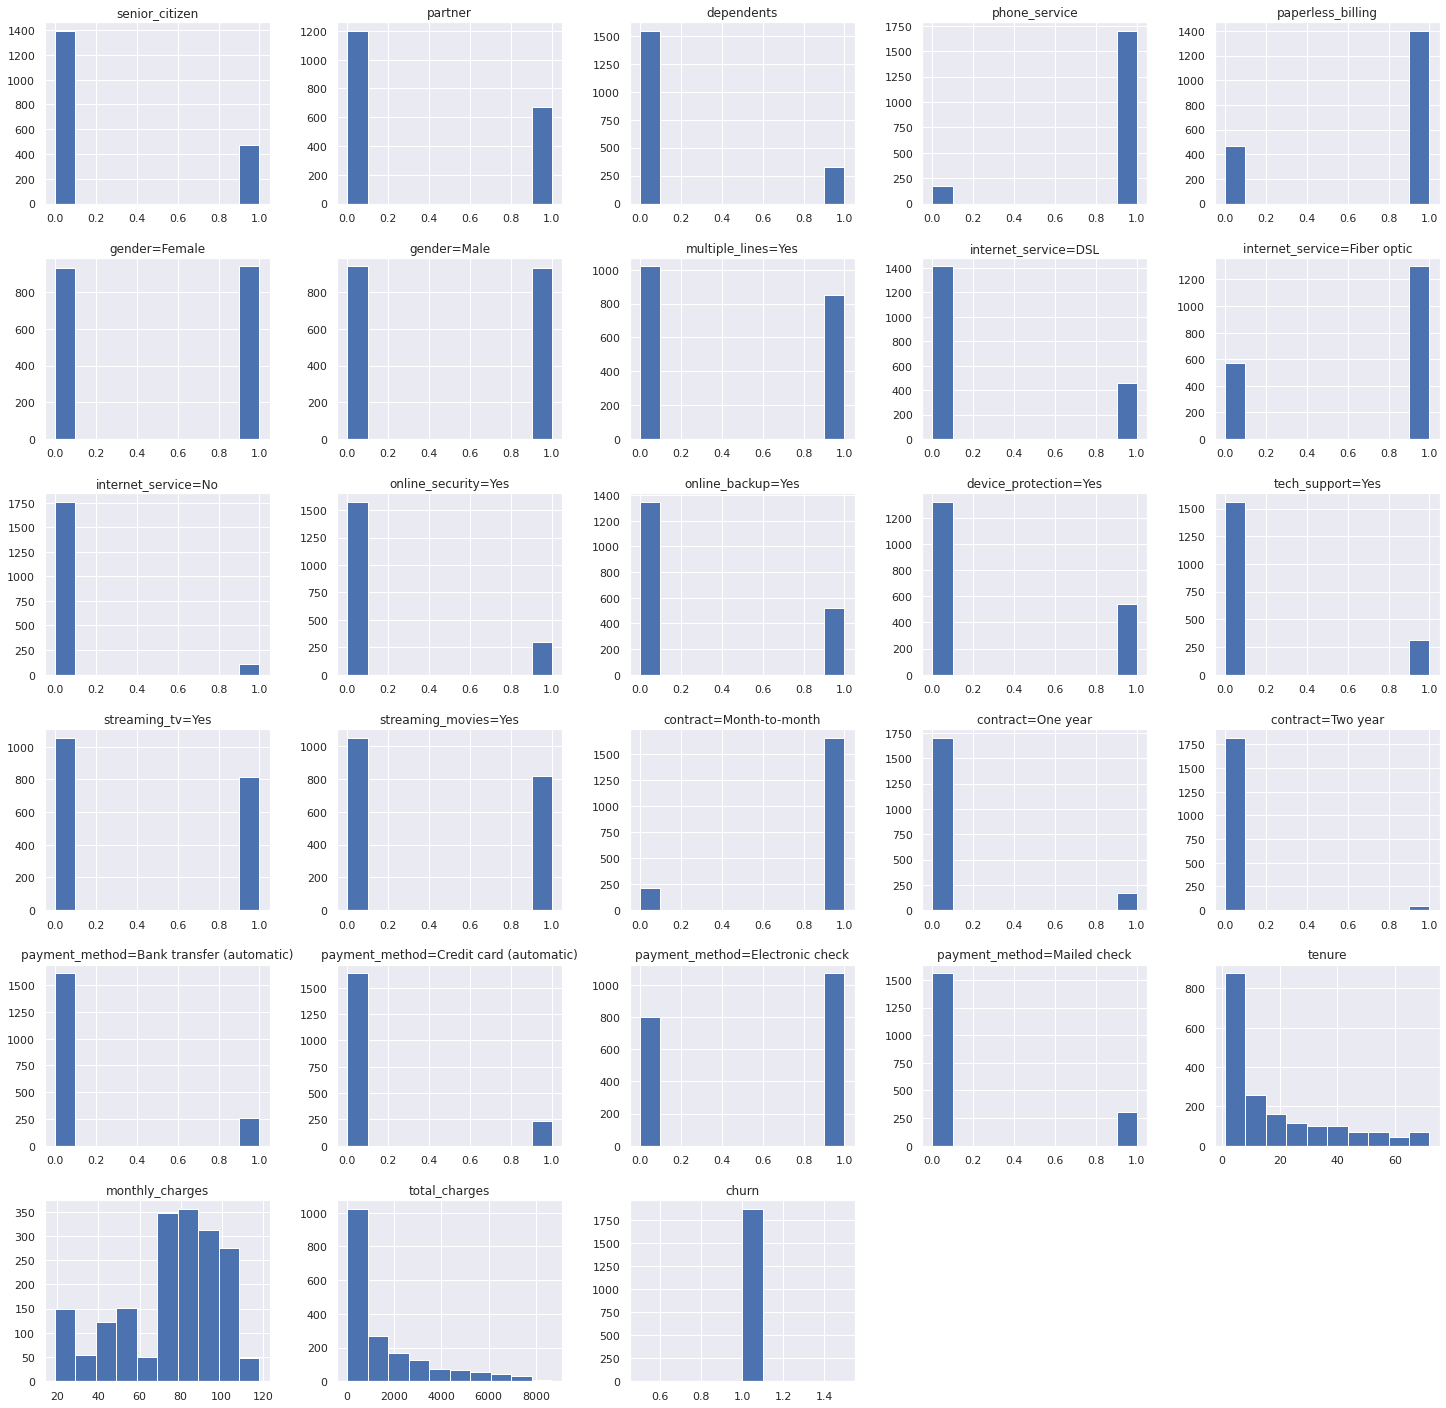

In [133]:
# Histograma
churn_df[ churn_df[TARGET_VARIABLE] == 1 ].hist(figsize = (25,25))
plt.show()

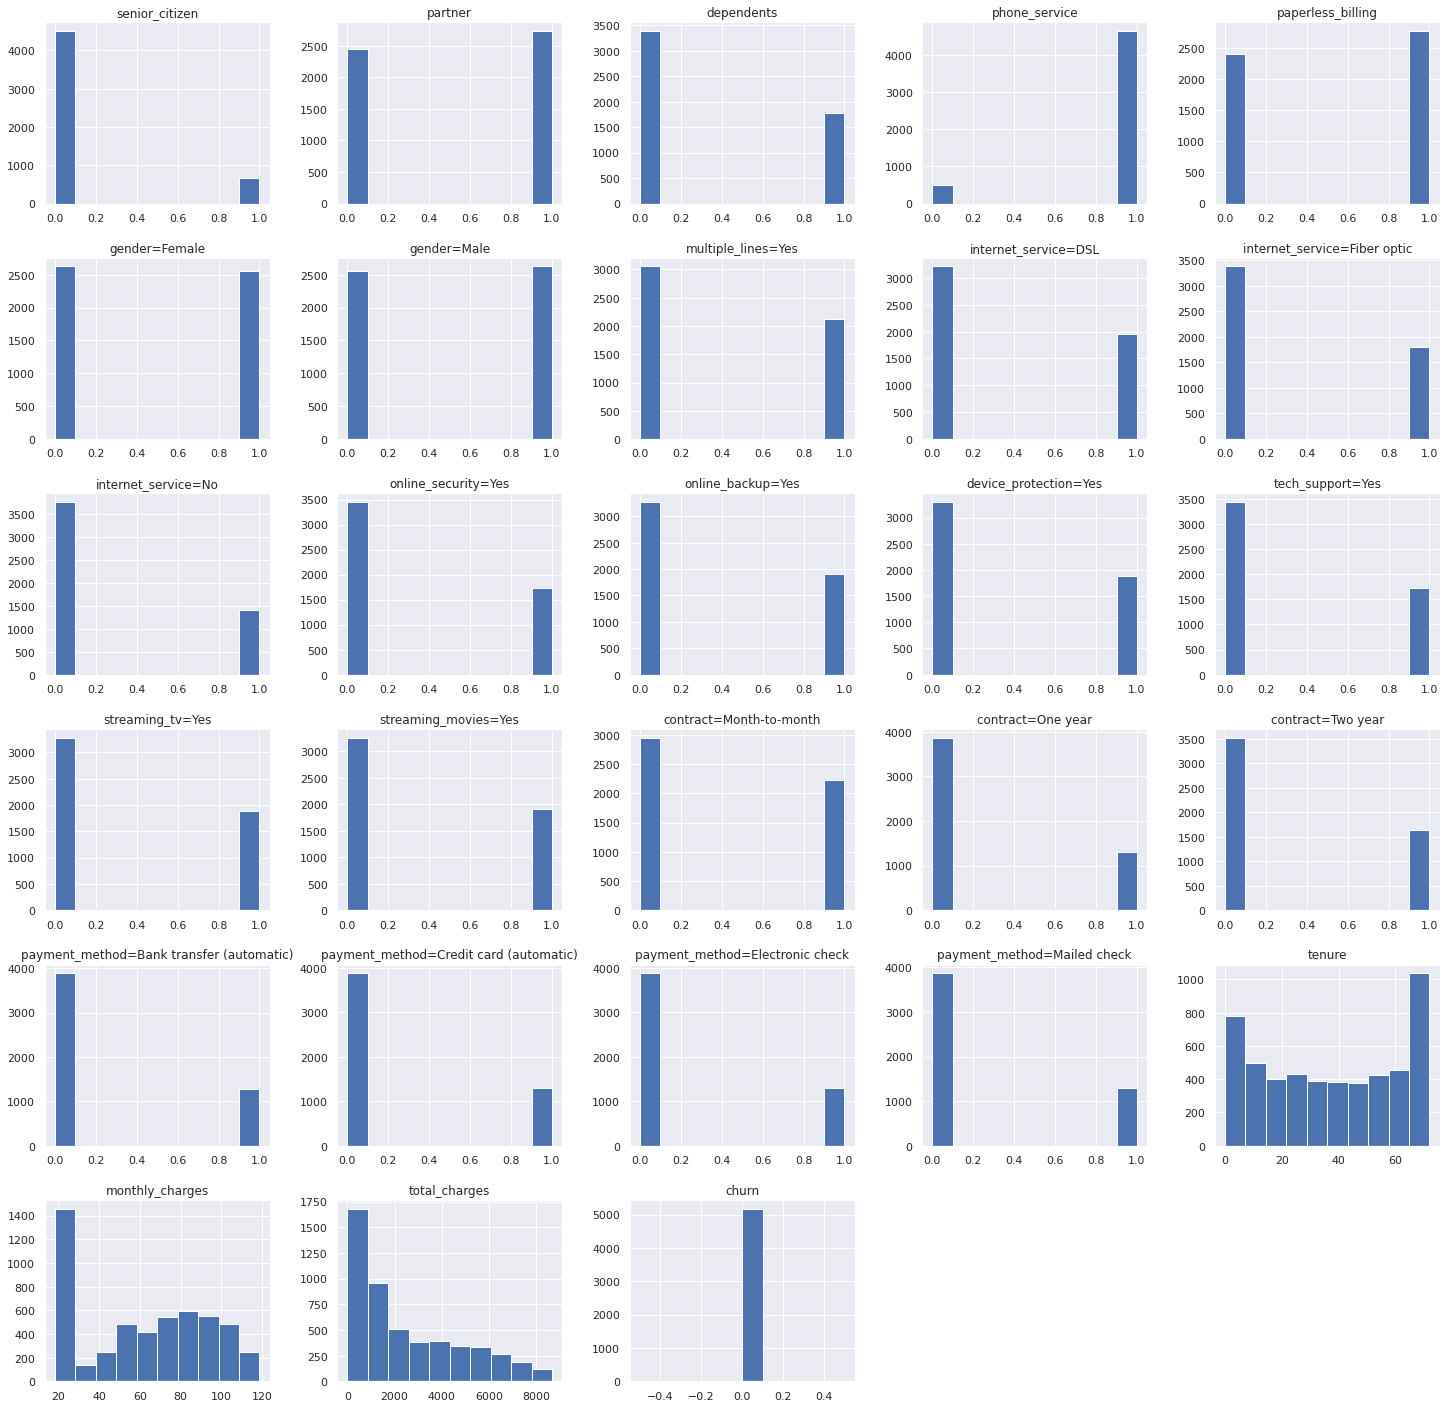

In [134]:
# Histograma
churn_df[ churn_df[TARGET_VARIABLE] == 0 ].hist(figsize = (25,25))
plt.show()


O Gráfico de Densidade, ou Density Plot, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, vamos criar um density plot para cada atributo do dataset.

Veremos que muitos dos atributos têm uma distribuição distorcida. Uma transformação como a Box-Cox, que pode aproximar a distribuição de uma Normal, pode ser útil neste caso.

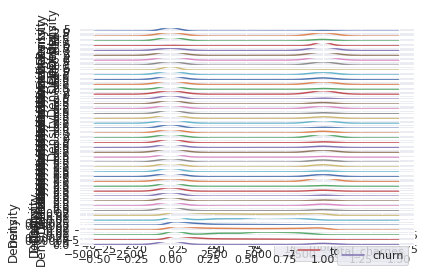

In [78]:
# Density Plot
churn_df.plot(kind = 'density', subplots = True, sharex = False)
plt.show()

Vamos agora trabalhar com boxplots. No **boxblot**, a linha no centro (vermelha) representa o valor da mediana (segundo quartil ou p50). A linha abaixo é o 1o quartil (p25) e a linha acima o terceiro quartil (p75). O boxplot ajuda a ter uma ideia da dispersão dos dataset e os possíveis outliers.

*OBS: Se um ponto do dataset é muito distante da média (acima de 3 desvios padrão da média), pode ser considerado outlier.*

Nos gráficos bloxplot, veremos que a dispersão dos atributos do dataset é bem diferente.

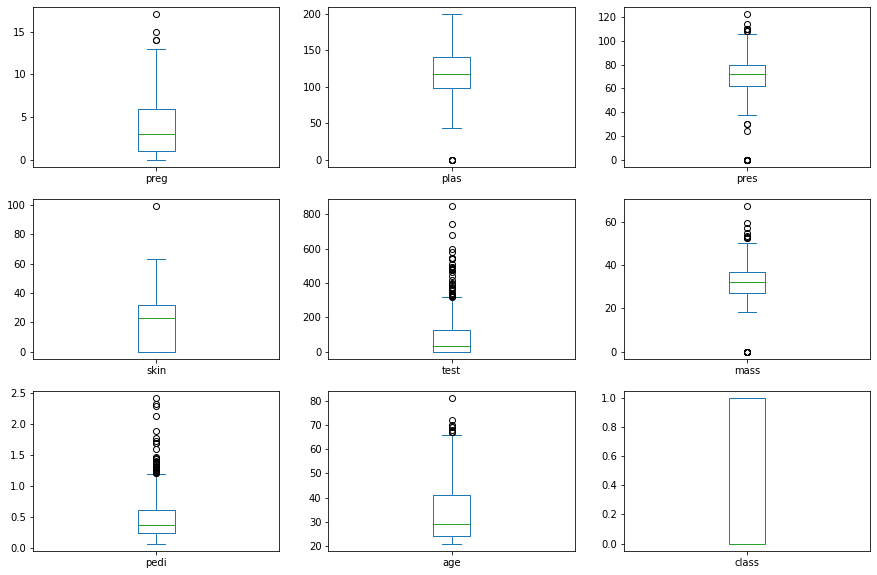

In [ ]:
# Boxplot
dataset.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

### 3.3. Visualizações Multimodais

Ao visualizar as correlações entre os atributos através da matriz de correlação, perceberemos que parece haver alguma estrutura na ordem dos atributos. O azul ao redor da diagonal sugere que os atributos que estão próximos um do outro são geralmente mais correlacionados entre si. Os vermelhos também sugerem alguma correlação negativa moderada, a medida que os atributos 

Vamos agora verificar a covariância entre as variáveis numéricas do dataset. A **covariância** representa como duas variáveis numéricas estão relacionadas. Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis, 
* Próximo de +1: há uma correlação positiva entre as variáveis. 
* 0: não há correlação entre as variáveis.

<i>OBS: Esta informação é relevante porque alguns algoritmos como regressão linear e regressão logística podem apresentar problemas de performance se houver atributos altamente correlacionados. Vale a pena consultar a documentação do algoritmo para verificar se algum tipo de tratamento de dataset é necessário.</i>

Falamos anteriormente da importância da correlação entre os atributos, e agora iremos visualizar esta informação em formato gráfico. A **matriz de correlação** exibe graficamente a correlação entre os atributos numéricos do dataset.estão mais distantes um do outro na ordenação. 

O código a seguir exibe a matriz de correlação.

tenure                                     -0.35
contract=Two year                          -0.30
internet_service=No                        -0.23
total_charges                              -0.20
contract=One year                          -0.18
online_security=Yes                        -0.17
tech_support=Yes                           -0.16
dependents                                 -0.16
partner                                    -0.15
payment_method=Credit card (automatic)     -0.13
internet_service=DSL                       -0.12
payment_method=Bank transfer (automatic)   -0.12
payment_method=Mailed check                -0.09
online_backup=Yes                          -0.08
device_protection=Yes                      -0.07
phone_service                               0.01
multiple_lines=Yes                          0.04
streaming_movies=Yes                        0.06
streaming_tv=Yes                            0.06
senior_citizen                              0.15
paperless_billing   

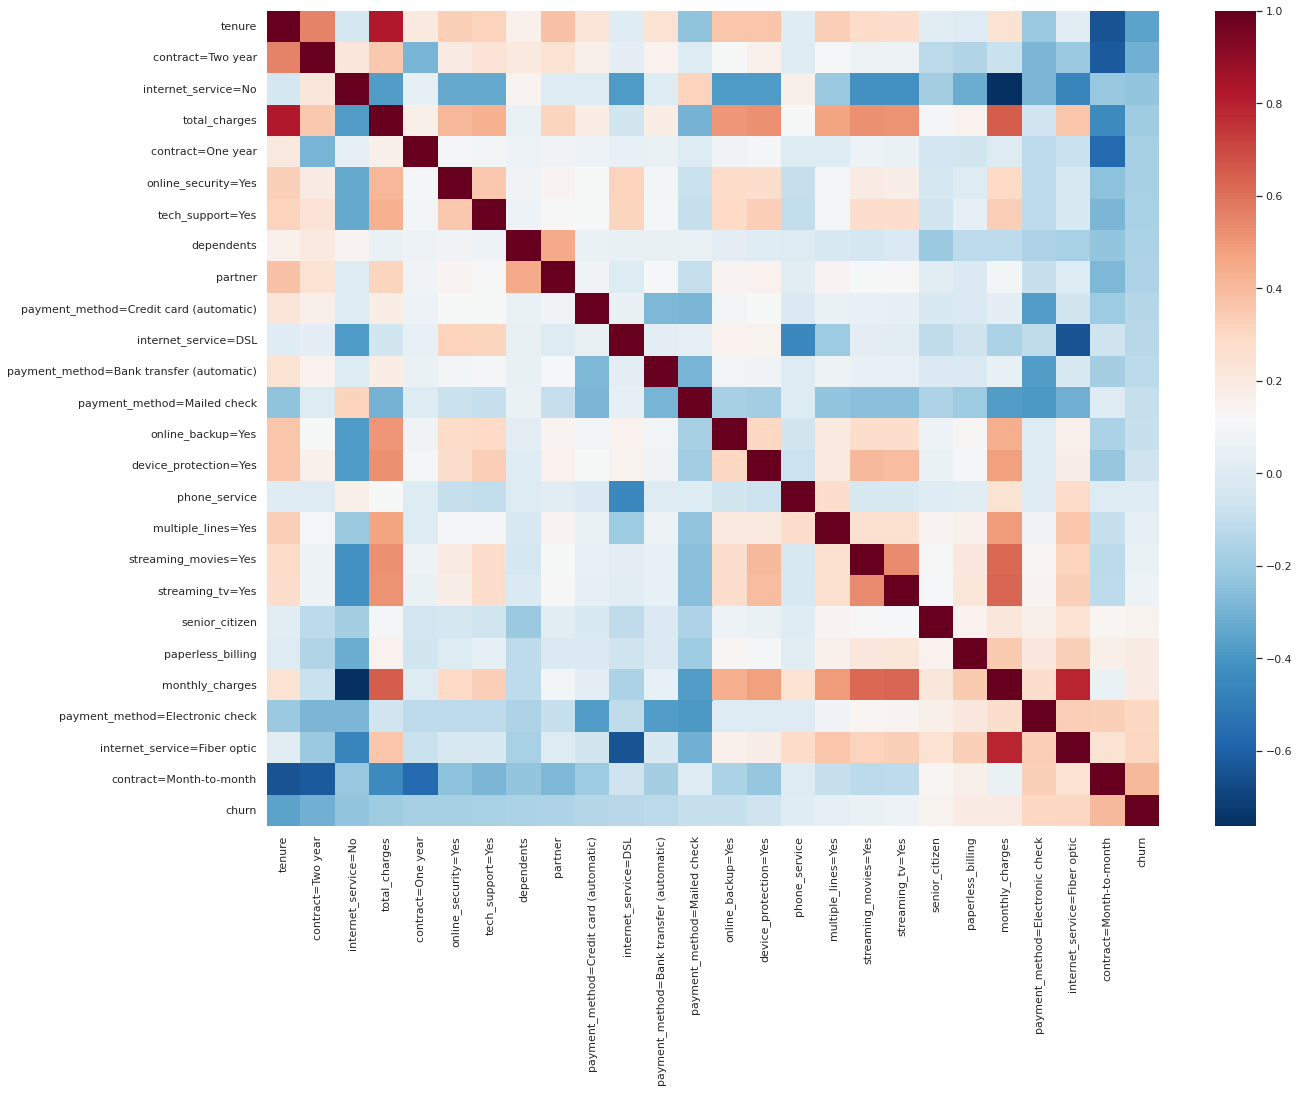

In [138]:
# Matriz de Correlação com Matplotlib Seaborn
corr_df = churn_df.corr()
corr_df.sort_values(by="churn", inplace=True, axis=0)
corr_df.sort_values(by="churn", inplace=True, axis=1)
sorted_churn_df = churn_df[ corr_df.columns ]
corr_df = sorted_churn_df.corr()
display(corr_df["churn"])
plt.subplots(figsize=(20,15))
sns.heatmap(corr_df, annot=False, cmap='RdBu_r');
"""
num_columns     = len(corr_df.columns)
low_corr_cols   = corr_df.columns[:10]
high_corr_cols  = corr_df.columns[-10:]
sorted_corr_df  = pd.concat([
    corr_df[low_corr_cols] 
,   corr_df[high_corr_cols]
], axis=1)
sns.heatmap(corr_df, annot=False, cmap='RdBu_r');
""";

Por sua vez, o gráfico de dispersão (**scatter plot**) mostra o relacionamento entre duas variáveis. Vamos exibir um para cada par de atributos dos dataset, usando o Seaborn.

In [40]:
# Scatter Plot com Seaborn - Variação 1

sns.pairplot(churn_ohe_df)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f6073b1b710> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f6073b25200> (for post_execute):


KeyboardInterrupt: ignored

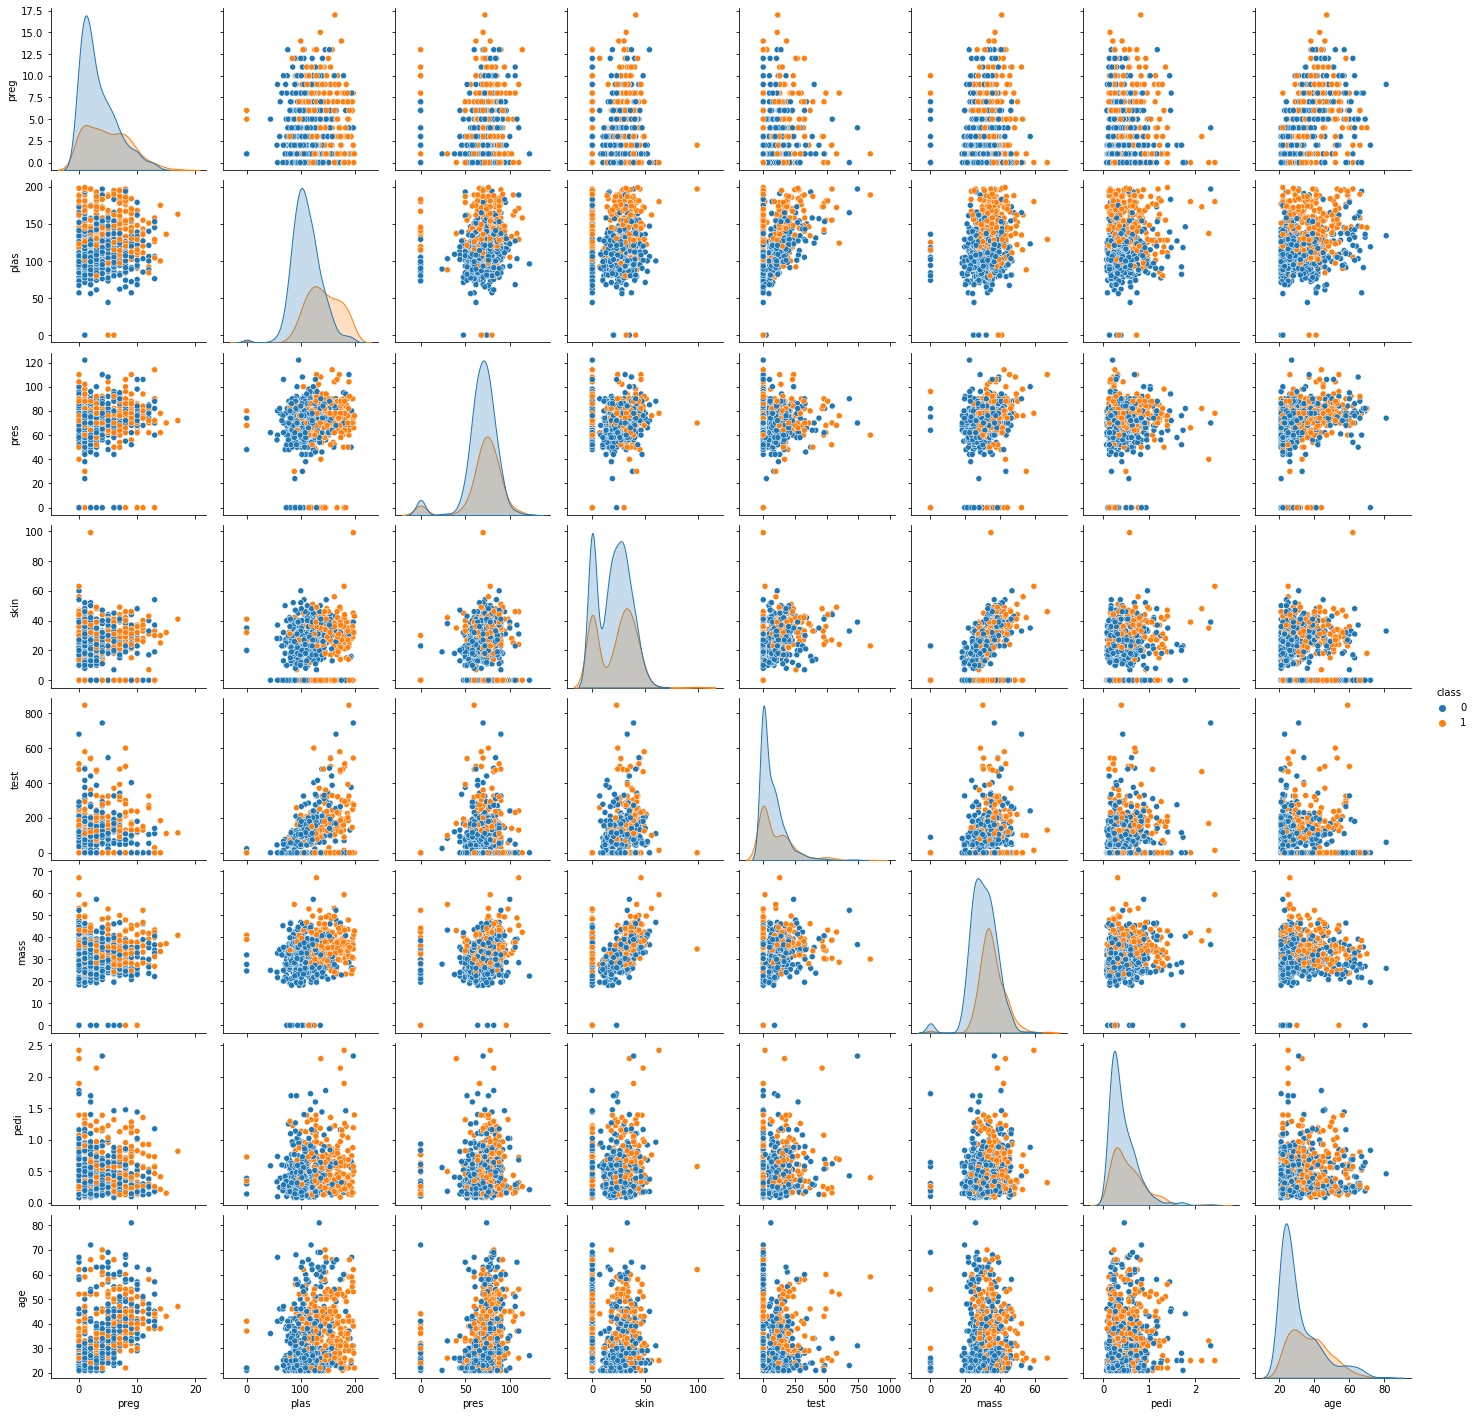

In [ ]:
# Scatter Plot com Seaborn - Variação 2

sns.pairplot(dataset, hue = "class", height = 2.5);

## 4. Pré-Processamento de dados

Nesta etapa, poderíamos realizar diversas operações de preparação de dados, como por exemplo, tratamento de valores missings (faltantes), limpeza de dados, transformações como one-hot-encoding, seleção de características (feature selection), entre outras não mostradas neste notebook. Lembre-se de não criar uma versão padronizada/normalizada dos dados neste momento (apesar de serem operações de pré-processamento) para evitar o Data Leakage.

### 4.1. Tratamento de Missings e Limpeza

Sabemos que o datset Diabetes não tem missings aparentes, mas valores "0" que parecem ser missings. Vamos então fazer este tratamento e criar uma nova visão do nosso dataset.

In [ ]:
# verificando nulls no dataset
dataset.isnull().sum()

preg     0
plas     0
pres     0
skin     0
test     0
mass     0
pedi     0
age      0
class    0
dtype: int64

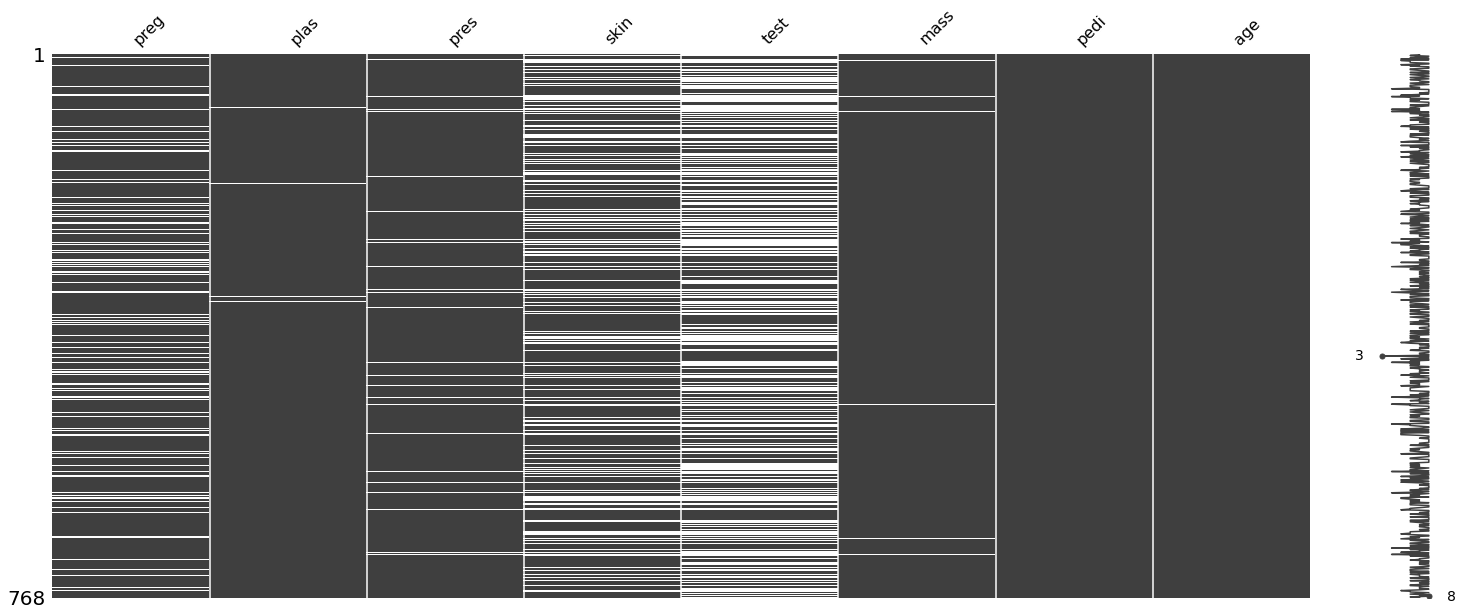

In [ ]:
# salvando um NOVO dataset para tratamento de missings (cuidado para não sobrescrever o dataset original!)

# recuperando os nomes das colunas
col = list(dataset.columns)

# o novo dataset irá conter todas as colunas com exceção da última (classe)
atributos = dataset[col[0:-1]]

# substituindo os zeros por NaN
atributos.replace(0, np.nan, inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

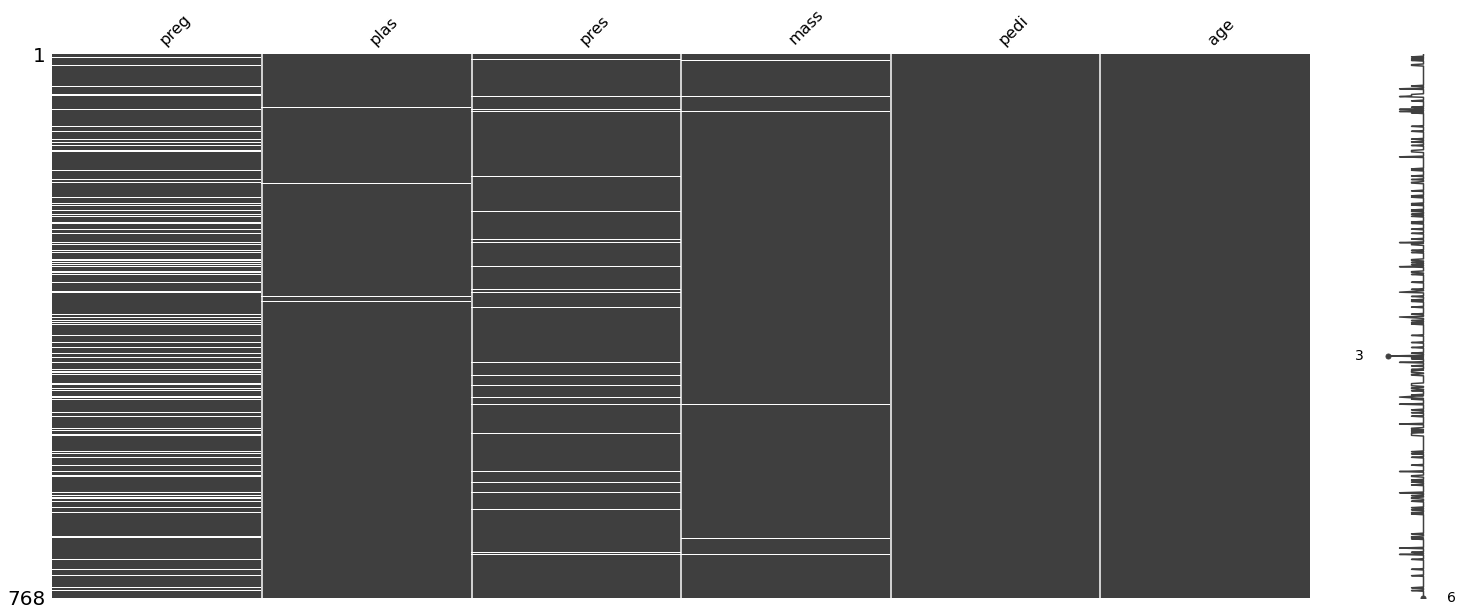

In [ ]:
# removendo as colunas 'skin' e 'test'
atributos.drop(['skin', 'test'], axis=1, inplace= True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

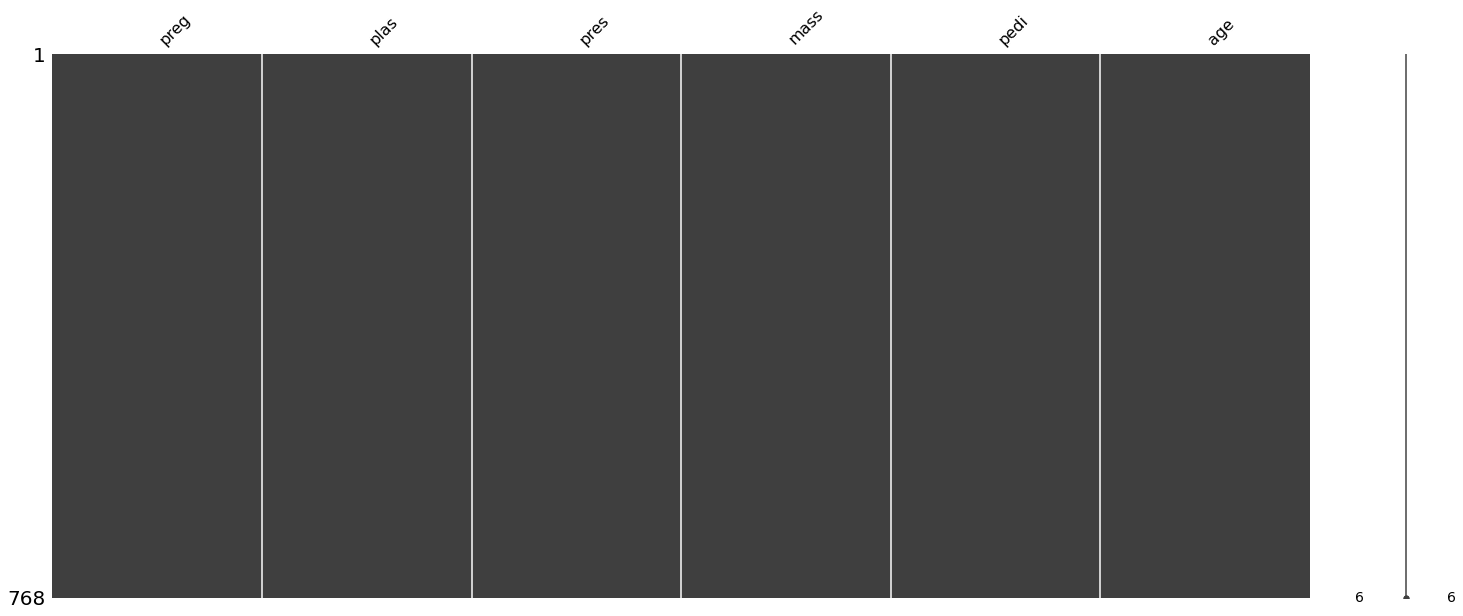

In [ ]:
# substituindo os NaN de 'preg' por 0
atributos['preg'].fillna(0, inplace=True)

# substituindo os NaN de 'plas', 'pres'e 'mass' pela mediana da coluna
atributos['plas'].fillna(atributos['plas'].median(), inplace=True)
atributos['pres'].fillna(atributos['pres'].median(), inplace=True)
atributos['mass'].fillna(atributos['mass'].median(), inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

In [ ]:
# Guardando o novo dataset para testes futuros
datasetSemMissings = atributos

# incluindo a coluna 'class' no novo dataset
datasetSemMissings['class'] = dataset['class']

# exibindo as primeiras linhas
datasetSemMissings.head()

,preg,plas,pres,mass,pedi,age,class
0,6.0,148.0,72.0,33.6,0.627,50,1
1,1.0,85.0,66.0,26.6,0.351,31,0
2,8.0,183.0,64.0,23.3,0.672,32,1
3,1.0,89.0,66.0,28.1,0.167,21,0
4,0.0,137.0,40.0,43.1,2.288,33,1


### 4.2. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste (na literatura também chamado de conjunto de validação), uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos. Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para teste, usando a estratégia train-test-split, já explicada anteriormente. Primeiramente, iremos sinalizar quais são as colunas de atributos (X - 0 a 7) e qual é a coluna das classes (Y - 8). Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados). Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: os atributos e classes para o conjunto de teste e os atributos e classes para o conjunto de treino.


In [ ]:
test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste (dataset original)
array = dataset.values
X = array[:,0:8]
y = array[:,8]
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#    test_size=test_size, shuffle=True, random_state=seed) # sem estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # com estratificação

In [ ]:
# Separação em conjuntos de treino e teste (dataset sem missings - 2 colunas a menos!)
array = datasetSemMissings.values
X_sm = array[:,0:6]
y_sm = array[:,6]
#X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm,
#    test_size=test_size, shuffle=True, random_state=seed) # sem estratificação
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y_sm) # com estratificação

## 5. Modelos de Classificação

### 5.1. Criação e avaliação de modelos: linha base

Não sabemos de antemão quais modelos performarão bem neste conjunto de dados. Assim, usaremos a validação cruzada 10-fold (já detalhada anteriormente) e avaliaremos os modelos usando a métrica de acurácia. Vamos inicialmente configurar os parâmetros de número de folds e métrica de avaliação.

In [ ]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
#kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=seed) # sem estratificação
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # com estratificação

Em seguida, vamos criar uma linha base de desempenho para esse problema, verificando vários modelos diferentes com suas configurações padrão. Utilizaremos os modelos de Regressão Logística (LR), Árvores de classificação (CART), Máquinas de vetores de suporte (SVM), Naive Bayes (NB) e K-vizinhos mais próximos (KNN).

In [ ]:
# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

Vamos adicionar também os algoritmos de ensemble que estudamos:

In [ ]:
np.random.seed(7) # definindo uma semente global

# definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# criando os modelos para o VotingClassifier - TODO: você poderia experimentar outras variações aqui!
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os modelos e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

Agora vamos comparar os resultados modelos criados, treinando-os com os dados do conjunto de treino e utilizando a técnica de validação cruzada. Para cada um dos modelos criados, executaremos a validação cruzada e, em seguida, exibiremos a acurácia média e o desvio padrão de cada um. Faremos isso tanto para o dataset original quanto para o dataset sem missings.

In [ ]:
# Aqui iremos armazenar os resultados tanto para o dataset original quanto para o dataset sem missings
results = []
names = []

In [ ]:
np.random.seed(7) # definindo uma semente global

# Avaliação dos modelos - dataset original

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.762427 (0.057485)
KNN: 0.711978 (0.058934)
CART: 0.702010 (0.063448)
NB: 0.746060 (0.051145)
SVM: 0.749418 (0.040958)
Bagging: 0.760814 (0.046503)
RF: 0.772263 (0.048493)
ET: 0.756002 (0.066055)
Ada: 0.749418 (0.052763)
GB: 0.750952 (0.057316)
Voting: 0.762507 (0.061246)


In [ ]:
np.random.seed(7) # definindo uma semente global

# Avaliação dos modelos - dataset sem missings

for name, model in models:
    cv_results = cross_val_score(model, X_train_sm, y_train_sm, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.757456 (0.045851)
KNN: 0.734506 (0.050838)
CART: 0.692226 (0.044920)
NB: 0.755870 (0.057395)
SVM: 0.760788 (0.041123)
Bagging: 0.763987 (0.034141)
RF: 0.762348 (0.035720)
ET: 0.759149 (0.037749)
Ada: 0.739662 (0.054412)
GB: 0.764014 (0.054441)
Voting: 0.757483 (0.040273)


*Dica: organize os resultados numéricos em tabelas, para facilitar a sua comparação.*

Estes resultados sugerem que, para ambos os datasets, diversos modelos têm potencial de trazerem bons resultados, porém, vale observar que estes são apenas valores médios de acurácia, sendo também prudente também observar a distribuição dos resultados dos folds da validação cruzada. Faremos isto comparando os modelos usando boxplots. Os 11 primeiros boxplots são referentes ao dataset original e os seguintes, ao dataset com tratamento de missings.

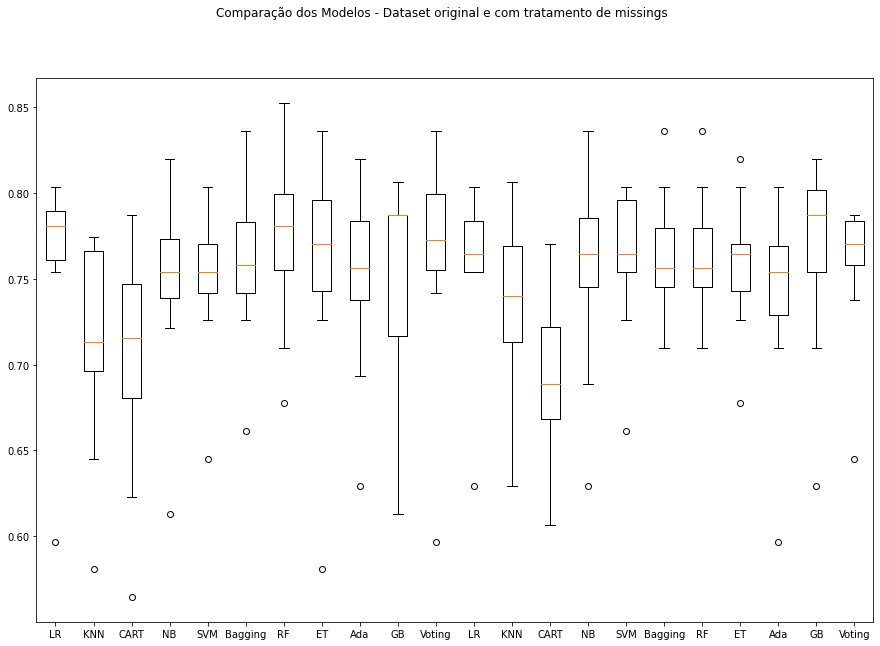

In [ ]:
# Comparação dos modelos
fig = plt.figure(figsize=(15,10)) 
fig.suptitle('Comparação dos Modelos - Dataset original e com tratamento de missings') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

Os resultados mostram algumas diferenças comparando o dataset original e o dataset com tratamento de missings, parecendo, inicialmente, que o dataset com tratamento de missings gerou melhores resultados (especialmente no KNN: observe a distribuição dos valores). Já considerando a mediana da acurácia marcada como a linha laranja do boxplot, os modelos de regressão logística parecem ter alcançado os melhores resultados.

A seguir, repetiremos este processo usando uma visão padronizada e outra normalizada do conjunto de dados de treinamento.

### 5.2. Criação e avaliação de modelos: dados padronizados e normalizados

Como suspeitamos que as diferentes distribuições dos dados brutos possam impactar negativamente a habilidade de alguns modelos, vamos agora experimentar as visões do dataset padronizado e normalizado, comparando com a visão original do dataset, com e tratamento de missings. Na padronização (*StandardScaler*), os dados serão transformados de modo que cada atributo tenha média 0 e um desvio padrão 1; na normalização (*MinMaxScaler*), cada atributo é redimensionado para um novo intervalo entre 0 e 1.

Para evitar o vazamento de dados (*data leakage*) nestas transformações, vamos usar pipelines que padronizam os dados e constroem o modelo para cada fold de teste de validação cruzada. Dessa forma, podemos obter uma estimativa justa de como cada modelo com dados padronizados pode funcionar com dados não vistos.

*OBS: Repare que neste notebook estamos usando um código mais "limpo" do que nos anteriores.*

In [ ]:
np.random.seed(7) # definindo uma semente global

# Aqui iremos armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Padronização do dataset original
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging]))) 
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Normalização do dataset original
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging]))) 
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines - datasets sem tratamento de missings
print("-- Datasets SEM tratamento de missings")
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Executando os pipelines - datasets com tratamento de missings
print("-- Datasets COM tratamento de missings")
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_sm, y_train_sm, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

-- Datasets SEM tratamento de missings
LR-orig: 0.762 (0.057)
KNN-orig: 0.712 (0.059)
CART-orig: 0.702 (0.063)
NB-orig: 0.746 (0.051)
SVM-orig: 0.749 (0.041)
Bag-orig: 0.761 (0.047)
RF-orig: 0.772 (0.048)
ET-orig: 0.756 (0.066)
Ada-orig: 0.749 (0.053)
GB-orig: 0.751 (0.057)
Vot-orig: 0.763 (0.061)
LR-padr: 0.762 (0.057)
KNN-padr: 0.727 (0.069)
CART-padr: 0.699 (0.048)
NB-padr: 0.746 (0.051)
SVM-padr: 0.763 (0.053)
Bag-padr: 0.772 (0.045)
RF-padr: 0.751 (0.048)
ET-padr: 0.776 (0.061)
Ada-padr: 0.749 (0.053)
GB-padr: 0.748 (0.058)
Vot-padr: 0.774 (0.047)
LR-norm: 0.751 (0.045)
KNN-norm: 0.725 (0.083)
CART-norm: 0.697 (0.069)
NB-norm: 0.746 (0.051)
SVM-norm: 0.772 (0.054)
Bag-norm: 0.766 (0.050)
RF-norm: 0.776 (0.043)
ET-norm: 0.767 (0.059)
Ada-norm: 0.749 (0.053)
GB-norm: 0.749 (0.058)
Vot-norm: 0.774 (0.049)
-- Datasets COM tratamento de missings
LR-orig: 0.757 (0.046)
KNN-orig: 0.735 (0.051)
CART-orig: 0.692 (0.054)
NB-orig: 0.756 (0.057)
SVM-orig: 0.761 (0.041)
Bag-orig: 0.761 (0.036)

Vamos analisar estes resultados graficamente:

*OBS: você pode preferir fazer um experimento com menos variações para comparar melhor os resultados graficamente, ou mesmo incluir neste gráfico algumas linhas verticais para separar as diferentes visões do dataset.*

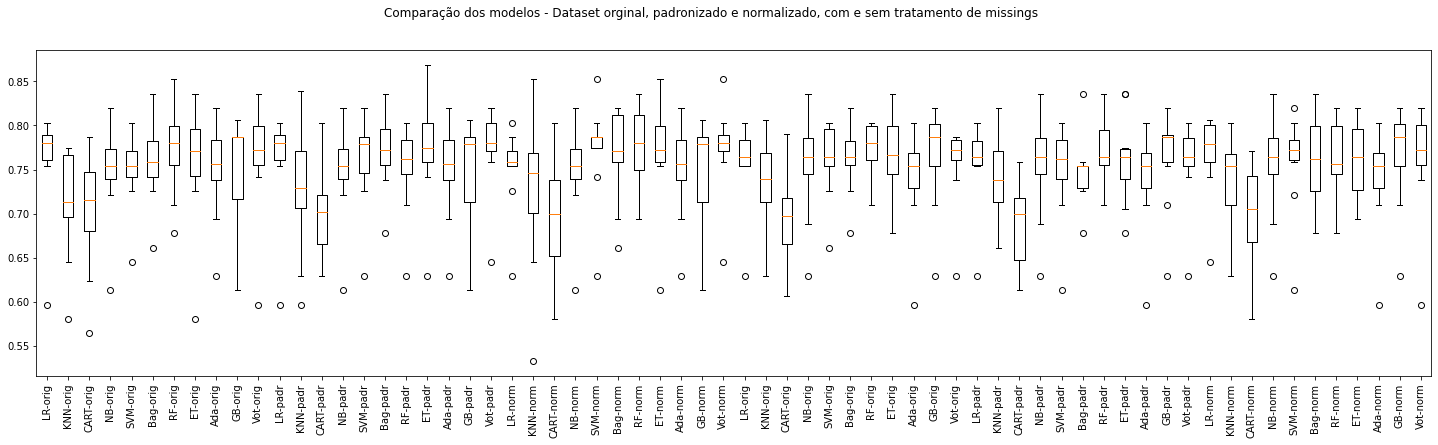

In [ ]:
# Comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos modelos - Dataset orginal, padronizado e normalizado, com e sem tratamento de missings') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

Neste primeiro experimento, rodamos 66 configurações: 11 diferentes algoritmos e 6 diferentes visões do nosso dataset!

Para o dataset **Sem tratamento de missings**, os melhores modelos em termos de acurácia foram: ET-orig (0,779), Bag-orig (0,77), LR-padr	(0,77), GB-orig	(0,769) e Bag-padr (0,767). Já para o dataset **Com tratamento de missings**, os melhores modelos foram: Vot-orig (0,774), ET-norm (0,77), SVM-norm (0,766), LR-padr (0,764) e RF-norm (0,764).

Vamos agora fazer um **novo experimento**, fazendo o ajuste do SVM e do KNN, variando os seus hiperparâmetros a fim de buscar configurações que possam gerar resultados melhores.

*OBS: Você poderia se aprofundar em outros algoritmos também.*

### 5.3. Ajuste dos Modelos (pipeline + gridsearch)

#### Ajuste do KNN

Vamos começar ajustando parâmetros como o número de vizinhos e as métricas de distância para o KNN. Para tal, tentaremos todos os valores ímpares de k entre 1 a 21 e as métricas de distância euclidiana, manhattan e minkowski. Usando o pipeline, cada valor de k e de distância será avaliado usando a validação cruzada 10-fold no conjunto de dados sem tratamento de missings e com as visões padronizada e normalizada, que mostrou melhores resultados do que os dados originais.

In [ ]:
# Tuning do KNN

# Baseado em https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

np.random.seed(7) # definindo uma semente global

pipelines = []

# definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn]))) # OBS: "steps=" é opcional
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Dataset sem tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)

    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

    # imprime todas as configurações
    #means = grid.cv_results_['mean_test_score']
    #stds = grid.cv_results_['std_test_score']
    #params = grid.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f): %r" % (mean, stdev, param))

# Dataset com tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sm, y_train_sm)

    # imprime a melhor configuração
    print("Com tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

Sem tratamento de missings: knn-orig - Melhor: 0.757615 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Sem tratamento de missings: knn-padr - Melhor: 0.757509 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-norm - Melhor: 0.759228 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}
Com tratamento de missings: knn-orig - Melhor: 0.764014 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}
Com tratamento de missings: knn-padr - Melhor: 0.763934 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}
Com tratamento de missings: knn-norm - Melhor: 0.773770 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}


Os resultados mostram que a melhor configuração encontrada utiliza o dataset com tratamento de missings, com dados padronizados, distância de manhattan e k = 15.

#### Ajuste do SVM
Iremos ajustar dois dos principais hiperparâmetros do algoritmo SVM: o valor de C (o quanto flexibilizar a margem) e o tipo de kernel utilizado. No Scikit-Learn, o padrão para o algoritmo SVM (implementado pela classe SVC) é usar o kernel da Função Base Radial (RBF) e o valor C definido como 1.0. 

Iremos testar outros valores para estes hiperparâmetros, e cada combinação de valores será avaliada usando a função GridSearchCV, como fizemos anteriormente para o KNN.

In [ ]:
# Tuning do SVM - DEMORA MUITO ESTE BLOCO DE CÓDIGO

# Baseado em https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

np.random.seed(7) # definindo uma semente global

pipelines = []

# definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm]))) # OBS: "steps=" é opcional
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'SVM__C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
    'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# Dataset sem tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)

    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

    # imprime todas as configurações
    #means = grid.cv_results_['mean_test_score']
    #stds = grid.cv_results_['std_test_score']
    #params = grid.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f): %r" % (mean, stdev, param))

# Dataset com tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sm, y_train_sm)

    # imprime a melhor configuração
    print("Com tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

Sem tratamento de missings: svm-orig - Melhor: 0.765680 usando {'SVM__C': 1.3, 'SVM__kernel': 'linear'}
Sem tratamento de missings: svm-padr - Melhor: 0.768932 usando {'SVM__C': 0.1, 'SVM__kernel': 'linear'}
Sem tratamento de missings: svm-norm - Melhor: 0.775568 usando {'SVM__C': 1.5, 'SVM__kernel': 'rbf'}
Com tratamento de missings: svm-orig - Melhor: 0.768958 usando {'SVM__C': 1.5, 'SVM__kernel': 'rbf'}
Com tratamento de missings: svm-padr - Melhor: 0.765653 usando {'SVM__C': 0.1, 'SVM__kernel': 'sigmoid'}
Com tratamento de missings: svm-norm - Melhor: 0.770571 usando {'SVM__C': 0.1, 'SVM__kernel': 'poly'}


Podemos ver que mesmo a configuração do SVM que alcançou a maior acurácia não supera a acurácia mais alta que conseguimos até o momento, com ensembles.


**Exercício:** Experimente variar os hiperparâmetros de outros algoritmos para verificar se é possível encontrar uma configuração de modelo que supere os melhoresd resultados até o momento.

## 7. Finalização do Modelo

Analisando os resultados até aqui, verificamos que o modelo que mostrou melhor acurácia média para o problema foi o que usou Extra Trees como algoritmo (apesar de ter um  desvio padrão relativamente alto). Relembrando o Experimento 1 (uma vez que o Experimento 2 não trouxe resultados melhores), nossos resultados foram:

*Para o dataset **Sem tratamento de missings**, os melhores modelos em termos de acurácia foram: ET-orig (0,779), Bag-orig (0,77), LR-padr	(0,77), GB-orig	(0,769) e Bag-padr (0,767). Já para o dataset **Com tratamento de missings**, os melhores modelos foram: Vot-orig (0,774), ET-norm (0,77), SVM-norm (0,766), LR-padr (0,764) e RF-norm (0,764).*

Examinando também o desvio padrão, poderíamos, por exemplo, optar por utilizar o modelo construído com o algoritmo de Regressão Logística, com os dados sem tratamento de missings, visão padronizada. Considerando o dataset "Sem tratamento de missings", este modelo ficou na 2a posição em termos de acurácia média, mas com um desvio padrão menor do que o que alcançou a 1a posição. Além disso, explicar como funciona este modelo para os usuários não técnicos tende a ser mais simples.

A seguir, finalizaremos este modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada) e faremos predições para o conjunto de dados de teste que foi separado logo no início do exemplo, a fim de confirmarmos nossas descobertas.

Primeiro, iremos realizar a padronização dos dados de entrada. Depois, treinaremos o modelo e exibiremos a acurácia de teste, a matriz de confusão e o relatório de classificação.

In [ ]:
# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200) # substitua aqui se quiser usar outro modelo
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7727272727272727
[[88 12]
 [23 31]]
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       100
         1.0       0.72      0.57      0.64        54

    accuracy                           0.77       154
   macro avg       0.76      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154



Por meio do conjunto de teste, verificamos que alcançamos uma acurácia de 77,22% em dados não vistos. Este resultado foi ainda melhor do que a nossa avaliação anterior da regressão logíistica. Valores semelhantes são esperados quando este modelo estiver executando em produção e fazendo predições para novos dados.

Vamos agora preparar o modelo para utilização. Para isso, vamos treiná-lo com todo o dataset, e não apenas o conjunto de treino.

In [ ]:
# Preparação do modelo com TODO o dataset (e não apenas a base de treino)
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

LogisticRegression(max_iter=200)

## 8. Aplicando o modelo em dados não vistos

Agora imagine que chegaram 3 novas instâncias, mas não sabemos a classe de saída. Podemos então aplicar nosso modelo recém-treinado para estimar as classes! Para tal, será necessário antes padronizar os dados (usando a mesma escala dos dados usados treinamento do modelo!).

In [ ]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],  
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)
print(X_entrada)

[[  1.  90.  50.  30. 100.  20.   1.  15.]
 [  9. 100.  60.  30. 100.  30.   2.  40.]
 [  5. 110.  50.  30. 100.  40.   1.  40.]]


In [ ]:
# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-0.84488505 -0.96691063 -0.98770975  0.59362962  0.17539902 -1.52208897
   1.59499624 -1.55207596]
 [ 1.53084665 -0.65393918 -0.47073225  0.59362962  0.17539902 -0.25289651
   4.61511492  0.57511787]
 [ 0.3429808  -0.34096773 -0.98770975  0.59362962  0.17539902  1.01629594
   1.59499624  0.57511787]]


In [ ]:
# Estimativa de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 1.]


## Resumo

Resumidamente, neste exemplo trabalhamos com um problema de classificação binária de ponta a ponta. As etapas abordadas foram:
* Definição do problema (Pima Indians Diabetes).
* Carga dos dados
* Análise  e tratamento dos dados (verificamos que estavam na mesma escala, mas com diferentes distribuições de dados e possíves missings).
* Avaliação de modelos de linha base, considerando o dataset original e com tratamento de missings.
* Avaliação de modelos com normalização e padronização dos dados.
* Ajuste dos modelos, buscando melhorar o KNN e o SVM.
* Finalização do modelo (use todos os dados de treinamento e valide usando o conjunto de dados de teste).

É importante ressaltar que este exemplo não buscou ser exaustivo, apresentando apenas uma parte dos muitos recursos disponíveis na biblioteca Scikit-Learn. Poderíamos ter testado outras operações de pré-processamento de dados (como feature selection), outros valores de hiperparâmetros e ainda, outros modelos de classificação. Recomendamos que você explore a documentação disponível e incremente este notebook com novas possibilidades.

## Para saber mais:
* Statistical Significance Tests for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
* Hypothesis Test for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/
* How to Calculate Parametric Statistical Hypothesis Tests in Python: https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/
* How to Use Statistical Significance Tests to Interpret Machine Learning Results: https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/
* 17 Statistical Hypothesis Tests in Python (Cheat Sheet): https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
